# k-means法（実データ）
- クラスタ数が既知の疑似データに加えて、クラスタ数が未知の実データを学習
- クラスタ数kを変化させて、結果がどのように変わるか確認しよう


## 1. ライブラリの読み込み

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 疑似データの生成
from sklearn.datasets import make_blobs
# k-means法の実装
from sklearn.cluster import KMeans

# Warningを非表示にする
import warnings
warnings.simplefilter('ignore')

# 標準化を行う
from sklearn.preprocessing import StandardScaler

## 2. クラスタ数が既知のデータ

### 2-1. 疑似データの生成
- scikit-learnの[make_blob()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)を用いる

,x1,x2,label
0,-46.233528,-31.385499,8
1,26.591767,-30.851087,3
2,-23.305483,-14.692841,7
3,-24.405911,-11.207747,7
4,-23.820724,-12.611908,7


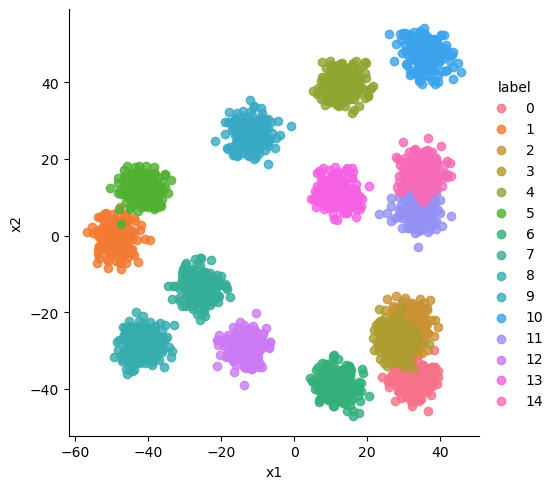

In [2]:
# 特徴Xとラベルyを生成
# サンプル数、クラスタ数、特徴の数、標準偏差、乱数シードを指定
# さらに中心点の範囲も指定
X, y = make_blobs(
    n_samples=3000, centers=15, n_features=2,
    cluster_std=3, random_state=2532689, 
    center_box=(-50, 50)
)
# 特徴Xをデータフレームに変換
df_data = pd.DataFrame(X, columns=["x1","x2"]) 
# ラベルy（クラスタ）をデータフレームに追加
df_data["label"] = y 

# データの確認
display(df_data.head())
# データの散布図を表示
# クラスタで色分け
sns.lmplot(
    x="x1", y="x2", hue="label", 
    data=df_data, fit_reg=False
)
plt.show()

### [演習]
* 任意のkでk-meansを実行し、結果の散布図を描画してみよう
* クラスターごとに色分けし、中心点も描画すること
* 最後にエルボー法の結果を描画してみよう

### 2-2. グラフ表示用の関数を定義

In [3]:
def plot_clusters(df_data, y_pred, centers):
    # データフレームにラベル（クラスタ）の予測値を追加
    df_data["label_pred"] = y_pred
    
    # データの散布図を表示
    # クラスタごとに色分け
    sns.lmplot(
        x="x1", y="x2", hue="label_pred", 
        data=df_data, fit_reg=False
    )
    # クラスタの中心点を赤色の×で表示
    plt.plot(
        centers[:,0], centers[:,1], 
        marker="x", ls="", color="r"
    )

### 2-3. クラスタリングの実行

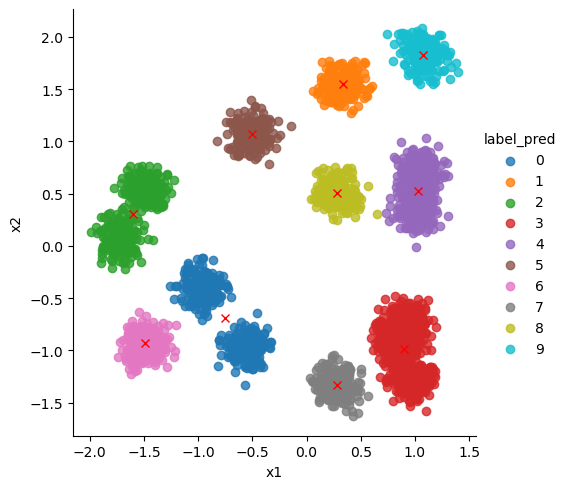

In [4]:
# 特徴Xの標準化
scaler = StandardScaler()
X_fake_std = scaler.fit_transform(X)
# データフレームを更新
df_data = pd.DataFrame(X_fake_std, columns=["x1","x2"])

# クラスタ数10のモデルを構築
k = 10
clf = KMeans(n_clusters=k)
# モデルの学習
clf.fit(X_fake_std)

# 予測値の計算
y_pred = clf.predict(X_fake_std)
# 中心点を取得
centers = clf.cluster_centers_

# クラスタリング結果の描画
# 赤色の×は中心点
plot_clusters(df_data, y_pred, centers)

### 2-4. エルボー法の実行
- エルボー法を用いて、最適なクラスタ数を探索
- ここではk=1～20とする

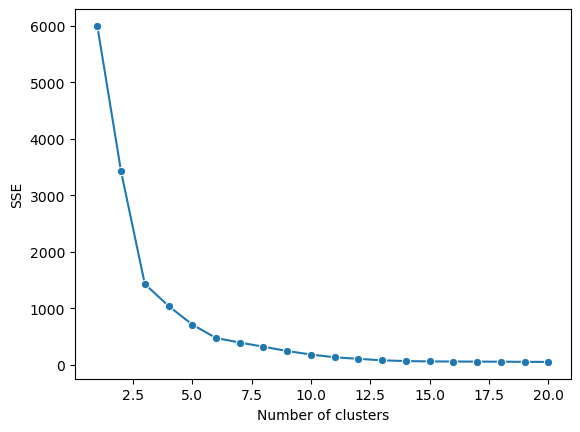

In [5]:
# エルボー法を行い、その結果をグラフ化
def plot_elbow(X, k_start, k_end):
    # SSEを格納するための配列
    sse = []
    # クラスタ数をk_startからk_endまで増やす
    for i in range(k_start, k_end+1):
        # モデルの構築
        clf = KMeans(n_clusters=i,random_state=1234)
        # モデルの学習
        clf.fit(X)
        # SSEの値を取得して配列に追加
        sse.append(clf.inertia_)

    # クラスタ数とSSEをまとめたデータフレームを作成
    df = pd.DataFrame({
        'Number of clusters': range(k_start, k_end+1), 
        'SSE': sse
    })
    # グラフの表示
    sns.lineplot(x='Number of clusters', y='SSE', data=df, marker="o")
    plt.show()
    
# 関数の実行
plot_elbow(X_fake_std, k_start=1, k_end=20)

## 3. クラスタ数が未知のデータ

- [Seeds from UCI](https://www.kaggle.com/datasets/dongeorge/seed-from-uci) 
    - 麦の種のサイズを記録したデータセット
    - 本来は目的変数（ラベル）も含まれているが、教師なし学習を行うために省略
- 説明変数：
    1. area, A：粒の断面積
    2. perimeter, P：粒の外周
    3. compactness, C = $\frac{4\pi A}{P^2}$：粒の緊密さ
    4. length of kernel, LK：粒の長さ
    5. width of kernel, WK：粒の幅
    6. asymmetry coefficient, A_coef：非対称性係数 
    7. length of kernel groove, LKG：粒の表面にある溝の長さ
  



### 3-1. データの読み込み

In [6]:
# CSVファイルの読み込み
df_seeds = pd.read_csv("../../1_data/ch14/seeds_dataset.csv", header=None, sep="\t")

# 列名を文字列に置き換え
feature_names = ["A", "P", "C", "LK", "WK", "A_coef", "LKG"] 
df_seeds.columns = feature_names

# データフレームの形状と中身を確認
print(df_seeds.shape)
display(df_seeds.head())
display(df_seeds.describe())

(210, 7)


,A,P,C,LK,WK,A_coef,LKG
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


,A,P,C,LK,WK,A_coef,LKG
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


### 3-2. データの可視化

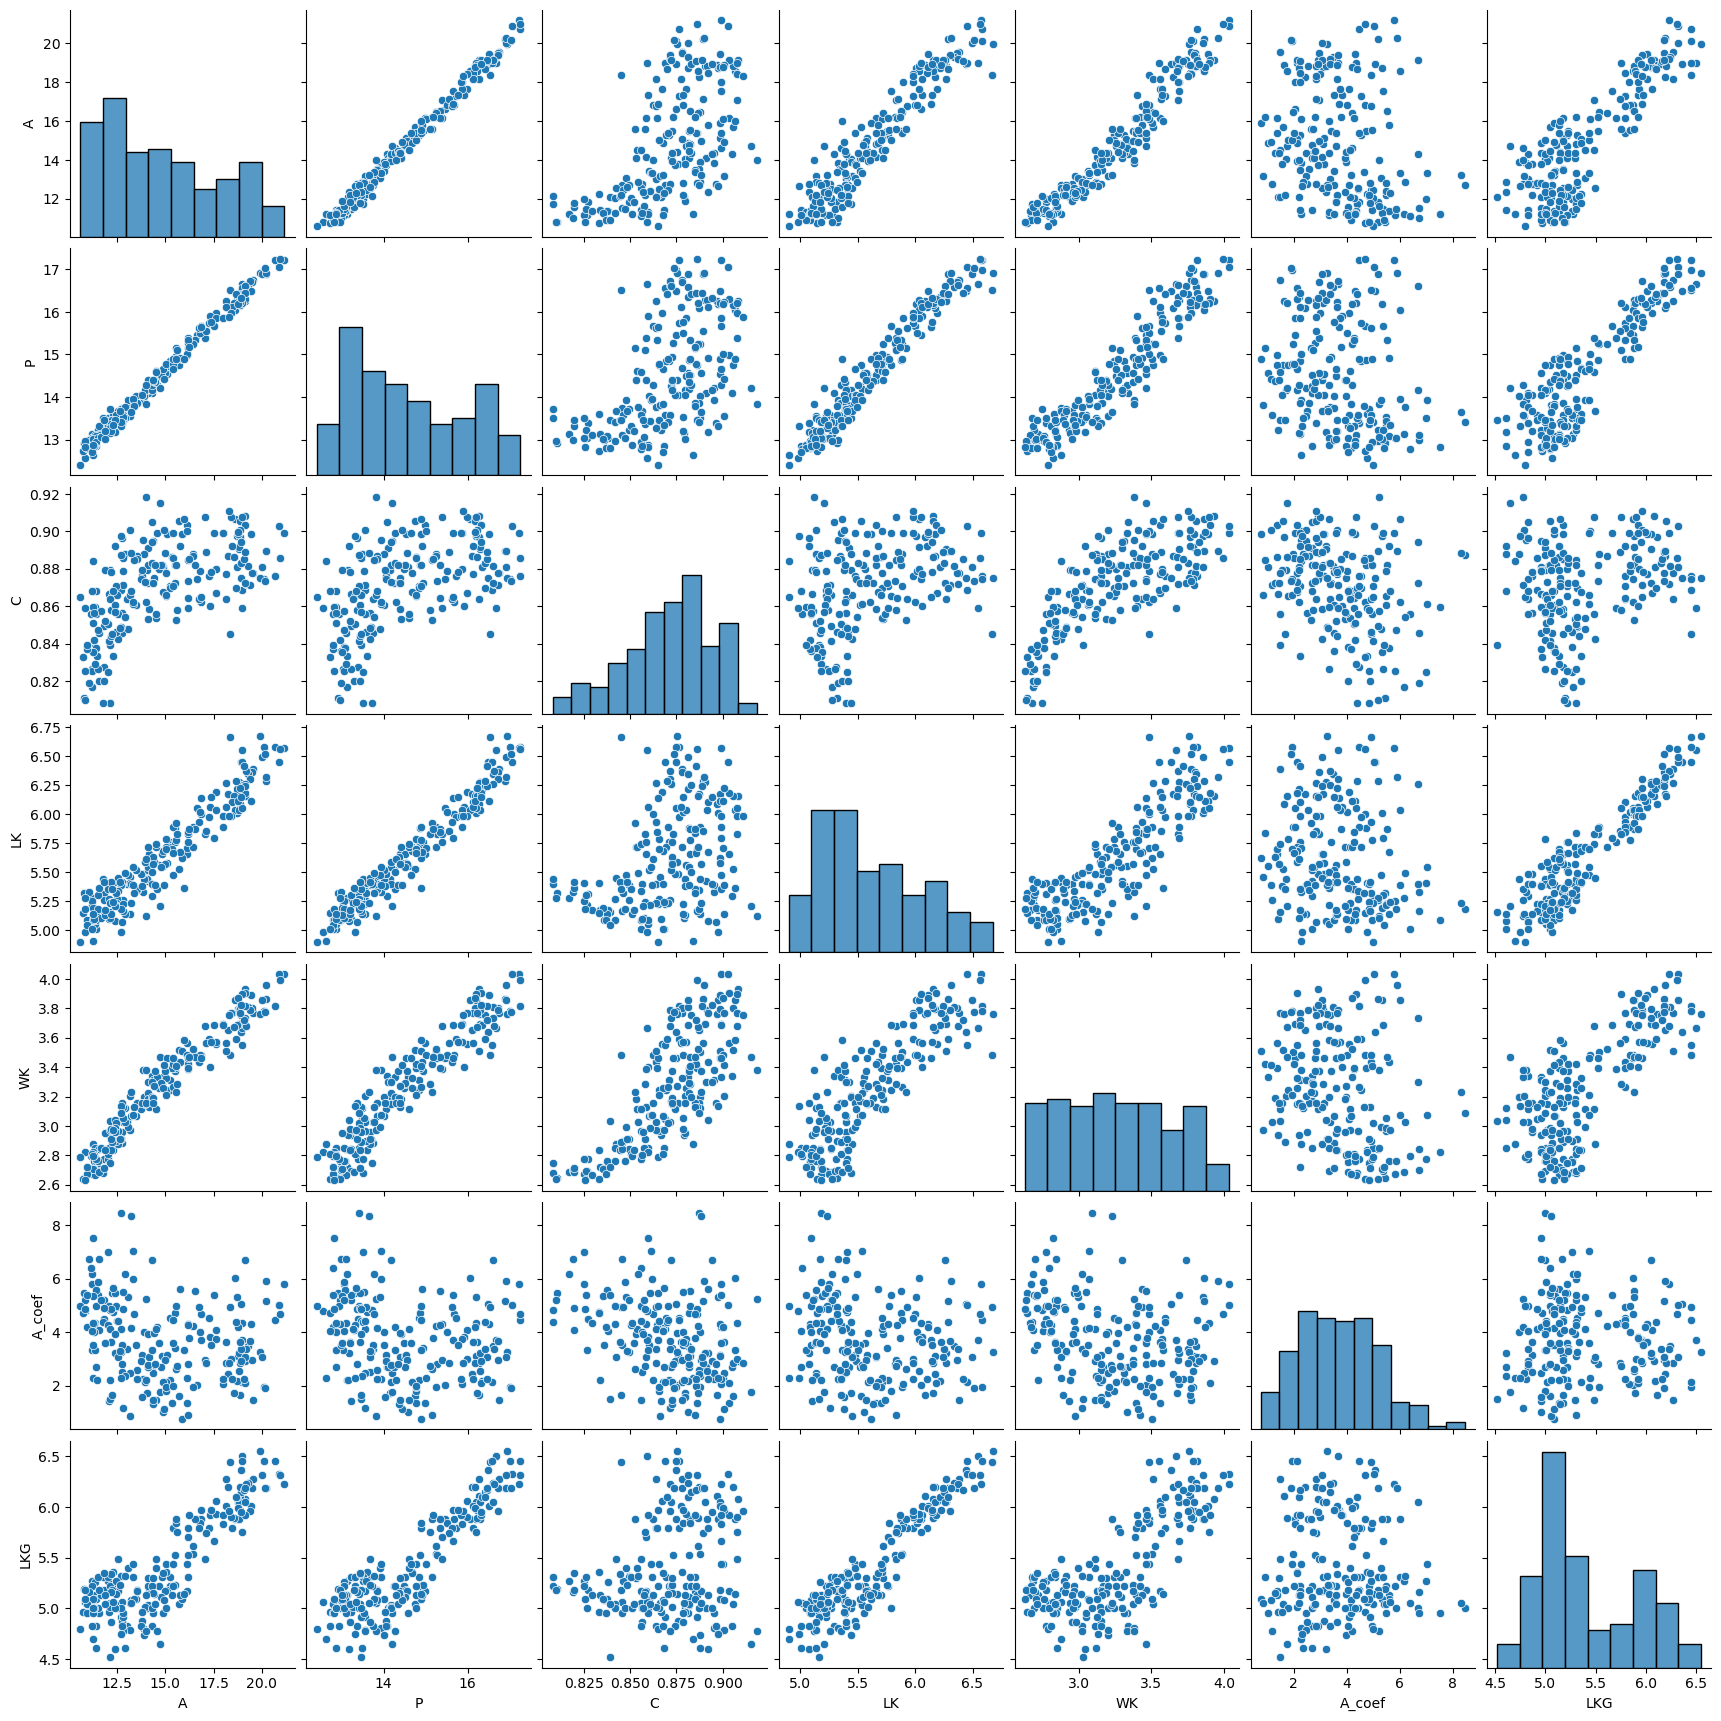

In [7]:
# 散布図行列の表示
sns.pairplot(df_seeds)
plt.show()

### 3-3. エルボー法の実行
- エルボー法を用いて、最適なクラスタ数を探索
- ここではk=1～10とする

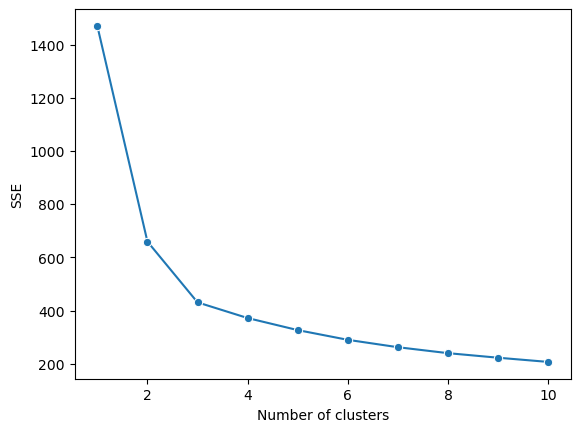

In [8]:
# 特徴Xの標準化
X_real = df_seeds.values
scaler = StandardScaler()
X_real_std = scaler.fit_transform(X_real)

# 関数の実行
plot_elbow(X_real_std, k_start=1, k_end=10)

### [問]
* 実際のクラスタ数はいくつだろうか？ 
* エルボー法の結果だけでなく、散布図も参考に考えてみよう